In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Hex Parachute Example

In [45]:
import numpy as np

import dismech

b = 0.02
h = 0.001

geom = dismech.GeomParams(rod_r0=1e-3,
                          shell_h=1e-3)

material = dismech.Material(density=1500,
                            youngs_rod=10e6,
                            youngs_shell=10e8,
                            poisson_rod=0.5,
                            poisson_shell=0.3)

dynamic_3d_sim = dismech.SimParams(static_sim=False,
                                   two_d_sim=False,
                                   use_mid_edge=False,
                                   use_line_search=False,
                                   show_floor=False,
                                   log_data=True,
                                   log_step=1,
                                   dt=5e-3,
                                   max_iter=25,
                                   total_time=3.0,
                                   plot_step=10,
                                   tol=1e-4,
                                   ftol=1e-4,
                                   dtol=1e-2)

env = dismech.Environment()
env.add_force('gravity', g=np.array([0.0, 0.0, -9.81]))
env.add_force('aerodynamics', rho=1, cd=10)

geo = dismech.Geometry.from_txt(
    'tests/resources/parachute/hexparachute_n6_python.txt')

robot = dismech.SoftRobot(geom, material, geo, dynamic_3d_sim, env)

In [46]:
from tqdm.notebook import tqdm
import cProfile

fixed_points = np.array([])


def simulate(robot, fixed_points):
    stepper = dismech.TimeStepper(robot, fixed_points)
    robot = stepper.robot   # update robot

    qs = []
    steps = int(robot.sim_params.total_time / robot.sim_params.dt) + 1
    for i in tqdm(range(1, steps)):
        new_robot = stepper.step()
        qs.append(new_robot.q)
    qs = np.stack(qs)
    return robot, qs

robot, qs = simulate(robot, fixed_points)

  0%|          | 0/600 [00:00<?, ?it/s]

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d.art3d import Line3DCollection, Poly3DCollection

# Define options (you can set any of these attributes)
from dataclasses import dataclass


@dataclass
class Options:
    free_node_color: str = 'blue'
    fixed_node_color: str = 'red'
    edge_color: str = 'black'
    face_color: tuple = (0.5, 0.5, 0.5, 0.3)
    title: str = "Dismech Simulation"
    x_lim: tuple = None
    y_lim: tuple = None
    z_lim: tuple = None
    camera_view: tuple = (30, 45)  # (elevation, azimuth) angles in degrees


def get_animation(robot, t, qs, options: Options):
    n_frames = qs.shape[0]
    n_nodes = len(robot.node_dof_indices)

    # Precompute mapping from node index to its dof indices.
    node_dof_list = [robot.map_node_to_dof(i) for i in range(n_nodes)]

    # Pre-compute node positions for each frame; shape (n_frames, n_nodes, 3)
    nodes_all = np.zeros((n_frames, n_nodes, 3))
    for frame in range(n_frames):
        q = qs[frame]
        for i, dofs in enumerate(node_dof_list):
            nodes_all[frame, i, :] = q[dofs]

    # Determine which nodes are fixed (assume node is fixed if all its dofs are fixed)
    fixed_set = set(robot.fixed_dof)
    node_is_fixed = np.array([all(d in fixed_set for d in dofs)
                             for dofs in node_dof_list])

    # Create figure and 3D axis.
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Set axis limits based on overall node positions.
    x_all = nodes_all[:, :, 0]
    y_all = nodes_all[:, :, 1]
    z_all = nodes_all[:, :, 2]

    # Set limit to [min, max] by default
    if options.x_lim is None:
        ax.set_xlim(x_all.min(), x_all.max())
    else:
        ax.set_xlim(*options.x_lim)
    if options.y_lim is None:
        ax.set_ylim(y_all.min(), y_all.max())
    else:
        ax.set_ylim(*options.y_lim)
    if options.z_lim is None:
        ax.set_zlim(z_all.min(), z_all.max())
    else:
        ax.set_zlim(*options.z_lim)

    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_zlabel('Z Position')
    ax.set_title(options.title)

    # Set the camera view
    ax.view_init(elev=options.camera_view[0], azim=options.camera_view[1])

    # Create scatter objects for free and fixed nodes.
    scatter_free = ax.scatter([], [], [], color=options.free_node_color, s=30)
    scatter_fixed = ax.scatter([], [], [], color=options.fixed_node_color, s=30)

    # --- Workaround for empty collections ---
    # Create dummy data so that autoscaling does not fail.
    dummy_edge = np.array([[[0, 0, 0], [0, 0, 0]]])
    dummy_face = [[[0, 0, 0], [0, 0, 0], [0, 0, 0]]]

    # Create a Line3DCollection for edges and add to the axis.
    edge_collection = Line3DCollection(
        dummy_edge, colors=options.edge_color, linewidths=1.5)
    ax.add_collection3d(edge_collection)

    # Create a Poly3DCollection for faces and add to the axis.
    face_collection = Poly3DCollection(
        dummy_face, facecolors=options.face_color, edgecolors='none')
    ax.add_collection3d(face_collection)

    # Create a text object for time display.
    time_text = ax.text2D(0.05, 0.95, "", transform=ax.transAxes)

    def init():
        # Remove dummy data during initialization.
        scatter_free._offsets3d = ([], [], [])
        scatter_fixed._offsets3d = ([], [], [])
        edge_collection.set_segments([])  # Remove dummy edge.
        face_collection.set_verts([])     # Remove dummy face.
        time_text.set_text("")
        return scatter_free, scatter_fixed, edge_collection, face_collection, time_text

    def update(frame):
        # Get node positions for this frame.
        nodes = nodes_all[frame]  # shape: (n_nodes, 3)

        # Separate free and fixed nodes.
        free_nodes = nodes[~node_is_fixed]
        fixed_nodes = nodes[node_is_fixed]

        # Update scatter positions.
        if free_nodes.size:
            scatter_free._offsets3d = (
                free_nodes[:, 0], free_nodes[:, 1], free_nodes[:, 2])
        else:
            scatter_free._offsets3d = ([], [], [])
        if fixed_nodes.size:
            scatter_fixed._offsets3d = (
                fixed_nodes[:, 0], fixed_nodes[:, 1], fixed_nodes[:, 2])
        else:
            scatter_fixed._offsets3d = ([], [], [])

        # Update edge segments using robot.edges.
        segments = []
        for edge in robot.edges:
            i, j = edge
            segments.append([nodes[i], nodes[j]])
        edge_collection.set_segments(segments)

        # Update face vertices using robot.face_nodes_shell.
        verts = []
        for face in robot.face_nodes_shell:
            i, j, k = face
            verts.append([nodes[i], nodes[j], nodes[k]])
        face_collection.set_verts(verts)

        # Update time display.
        time_text.set_text(
            f"Time: {t[frame]:.2f}s (Step: {frame+1}/{n_frames})")
        return scatter_free, scatter_fixed, edge_collection, face_collection, time_text

    # Create the animation (using blit=False for 3D plots).
    ani = FuncAnimation(
        fig, update, frames=n_frames, init_func=init,
        interval=50, blit=False
    )

    return ani

In [72]:
%matplotlib notebook
from IPython.display import HTML
t = np.arange(robot.sim_params.total_time, step=robot.sim_params.dt)  # (100)
options = Options(title='Hex Parachute (N=6)',
                  camera_view=(5,45))

# Get the animation
ani = get_animation(robot, t[550:], qs[550:], options)
#ani.save('hex_parachute.gif', 'pillow')
HTML(ani.to_jshtml())

<IPython.core.display.Javascript object>

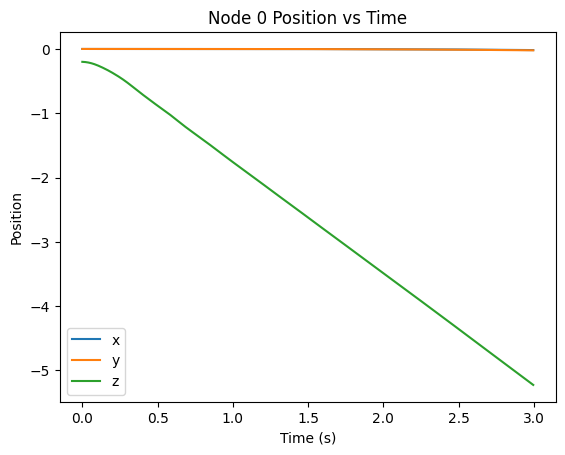

[-0.0174896  -0.02119769 -5.22515716]


In [61]:
%matplotlib inline
log_node_index = 0

node_pos = qs[:,robot.map_node_to_dof(log_node_index)]
plt.plot(t, node_pos, label=['x','y','z'])
plt.title("Node {} Position vs Time".format(log_node_index))
plt.xlabel("Time (s)")
plt.ylabel("Position")
plt.legend()
plt.show()
print(node_pos[-1])